In [1]:
import pandas as pd
import numpy as np
import cvxpy as cp
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal


file_path = 'data.xlsx'

time_train = 30 # training size

df = pd.read_excel(file_path)
asset_num = 30 # asset number
infor_num = 3 # contextual information number
asset_num_index = asset_num+1
asset_all = df.iloc[:, 1:asset_num_index].to_numpy()
infor_all = df.iloc[:, -infor_num:].to_numpy()
all_data = df.iloc[:, 1:].to_numpy()
print("all time num is ", asset_all.shape[0])

all time num is  456


In [2]:
po_list = []
mad_list = []
rcmad_list = []

In [3]:
 # MV model
for time_window_idx in range(asset_all.shape[0]-time_train):
    asset = df.iloc[time_window_idx:time_train+time_window_idx, 1:asset_num_index].to_numpy()
    infor = df.iloc[time_window_idx:time_train+time_window_idx, -infor_num:].to_numpy()
    all_data_train = df.iloc[time_window_idx:time_train+time_window_idx, 1:].to_numpy()
    
    asset_test = df.iloc[time_train+time_window_idx, 1:asset_num_index].to_numpy()
    infor_test = df.iloc[time_train+time_window_idx, -infor_num:].to_numpy()
    

    asset_mean = np.mean(asset, axis=0)
    asset_std = np.std(asset, axis=0)
    asset_sig = np.diag(asset_std)
    asset_sig = asset_sig.T.dot(asset_sig)
    n_asset = asset.shape[1]
    T_val = asset.shape[0]

    # PO
    w = cp.Variable(n_asset)
    gamma = 3
    ret = asset_mean.T @ w
    risk = cp.quad_form(w, asset_sig)
    prob = cp.Problem(cp.Maximize(ret - gamma * risk), [cp.sum(w) == 1, w >= 0])
    prob.solve()
    po_list.append(asset_test.T @ w.value)


    

In [4]:
# MAD model

for time_window_idx in range(asset_all.shape[0]-time_train):    
    asset = df.iloc[time_window_idx:time_train+time_window_idx, 1:asset_num_index].to_numpy()
    infor = df.iloc[time_window_idx:time_train+time_window_idx, -infor_num:].to_numpy()
    all_data_train = df.iloc[time_window_idx:time_train+time_window_idx, 1:].to_numpy()
    
    asset_test = df.iloc[time_train+time_window_idx, 1:asset_num_index].to_numpy()
    infor_test = df.iloc[time_train+time_window_idx, -infor_num:].to_numpy()
    

    asset_mean = np.mean(asset, axis=0)
    asset_std = np.std(asset, axis=0)
    asset_sig = np.diag(asset_std)
    asset_sig = asset_sig.T.dot(asset_sig)
    n_asset = asset.shape[1]
    T_val = asset.shape[0]


    # MAD
    y_t = cp.Variable(T_val)
    R_0 = po_list[time_window_idx]   # desired return
    r_i = asset_mean
    r_it = asset
    r_red_mat = np.zeros((T_val,n_asset))
    for time_index in range(T_val):
        rit_time = np.array([r_it[time_index,:] - r_i])
        for ele in range(n_asset):
            r_red_mat[time_index, ele] = rit_time[0, ele]
    y_t = cp.Variable(T_val)
    R_0 = ret.value  
    r_i = asset_mean
    r_it = asset
    y_t = cp.Variable(T_val)
    omega = cp.Variable(n_asset)
    objective = cp.Minimize((1/T_val) * cp.sum(y_t))
    constraints = [
    r_i.T @ omega >= R_0,
    cp.sum(omega) == 1.0,
    ]
    constraints +=[omega >= 0.0,
    y_t >= 0.0,
              ]
    constraints += [
        y_t+ r_red_mat @ omega >= 0,
        y_t- r_red_mat @ omega >= 0,
    ]
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS)
    if problem.status == cp.OPTIMAL:
        mad_list.append(asset_test.T @ omega.value)
    else:
        mad_list.append(R_0)

    

/home/xushaohang/new_disk_research_only/Finance/RC_MAD/venv/lib/python3.8/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [6]:
# RCMAD model
for time_window_idx in range(asset_all.shape[0]-time_train):   
    asset = df.iloc[time_window_idx:time_train+time_window_idx, 1:asset_num_index].to_numpy()
    infor = df.iloc[time_window_idx:time_train+time_window_idx, -infor_num:].to_numpy()
    all_data_train = df.iloc[time_window_idx:time_train+time_window_idx, 1:].to_numpy()
    
    asset_test = df.iloc[time_train+time_window_idx, 1:asset_num_index].to_numpy()
    infor_test = df.iloc[time_train+time_window_idx, -infor_num:].to_numpy()
    
 
    asset_mean = np.mean(asset, axis=0)
    asset_std = np.std(asset, axis=0)
    asset_sig = np.diag(asset_std)
    asset_sig = asset_sig.T.dot(asset_sig)
    n_asset = asset.shape[1]
    T_val = asset.shape[0]


    # RCMAD
    n_components = 2
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(all_data_train)
    gmm_means = gmm.means_
    gmm_covariances = gmm.covariances_
    gmm_weights = gmm.weights_
    # calculate conditional GMM
    side_information_now = infor_all[time_train+time_window_idx,:] # the 31st year
    p_i_k = np.array([0.0]*n_components)
    for idx_component in range(n_components):
        mean =  gmm_means[idx_component][-infor_num:]
        cov =  gmm_covariances[idx_component][-infor_num:,-infor_num:]
        up_probability_density = multivariate_normal.pdf(side_information_now, mean=mean, cov=cov)
        low_probability_density = 0
        for idx_component_inner in range(n_components): 
            mean_inner =  gmm_means[idx_component_inner][-infor_num:]
            cov_inner =  gmm_covariances[idx_component_inner][-infor_num:,-infor_num:]
            probability_density_inner = multivariate_normal.pdf(side_information_now, mean=mean, cov=cov)
            low_probability_density+=gmm_weights[idx_component_inner] * probability_density_inner
        p_i_k[idx_component] = (gmm_weights[idx_component]*up_probability_density)/(low_probability_density)
    
    mu_i_k = np.zeros((n_components,asset_num))
    mu_r_k = gmm_means[:,:asset_num]
    mu_s_k = gmm_means[:,asset_num:]
    cov_rs_k = []
    for i in range(n_components):
        cov_rs_k.append(gmm_covariances[i][:asset_num,asset_num:])
    cov_ss_k = []
    for i in range(n_components):
        cov_ss_k.append(gmm_covariances[i][-infor_num:,-infor_num:])
    
    mu_i_k = np.zeros((n_components,asset_num))
    for i in range(n_components):
        mu_i_k[i] = mu_r_k[i] + cov_rs_k[i]@(np.linalg.inv(cov_ss_k[i]))@(side_information_now-mu_s_k[i])
    # define A and b
    A = np.zeros((2 * asset_num, asset_num))
    for i in range(asset_num):
        A[2*i][i] = -1
        A[2*i + 1][i] = 1
    
    B = np.zeros((2 * asset_num, 1))
    theta_lower_bound = - 0.1 # uncertainty bound
    theta_upper_bounbd = 0.1
    for i in range(asset_num):
        B[2*i] = - theta_lower_bound
        B[2*i + 1] = theta_upper_bounbd
    R_0 = mad_list[time_window_idx]  # desired return
    r_i = asset_mean
    r_it = asset
    
    y_t = cp.Variable(T_val)
    omega = cp.Variable(n_asset)
    
    gammas = []
    for i in range(n_components):
        gammas.append(cp.Variable(2*asset_num))
    betas = []
    for i in range(n_components):
        betas.append(cp.Variable(2*asset_num))
    alphas = []
    for i in range(n_components):
        alphas.append(cp.Variable(2*asset_num))
    
    # objective
    objective = cp.Minimize((1/T_val) * cp.sum(y_t))
    
    # Define the constraints
    
    constraints = [
        cp.sum(omega) == 1.0,
        omega >= 0.0,
        y_t >= 0.0
    ]
    
    for k in range(n_components): 
        constraints+=[gammas[k]>=0.0]
        constraints+=[betas[k]>=0.0]
        constraints+=[alphas[k]>=0.0]
    
    # equalities
    a_gama_sum=0
    for k in range(n_components):
        for m in range(2*asset_num):
            a_gama_sum += gammas[k][m]*A[m]
        constraints+=[p_i_k [k] *omega +a_gama_sum == 0.0]
    a_beta_sum=0
    for k in range(n_components):
        for m in range(2*asset_num):
            a_beta_sum += betas[k][m]*A[m]
        constraints+=[p_i_k [k] *omega +a_beta_sum == 0.0]
    a_alpha_sum=0
    for k in range(n_components):
        for m in range(2*asset_num):
            a_alpha_sum += alphas[k][m]*A[m]
        constraints+=[-p_i_k [k] *omega + a_alpha_sum == 0.0]
    
    # inequalities
    omega_mu_sum=0
    for k in range(n_components):
        omega_mu_sum+= p_i_k [k] * mu_i_k[k]@omega
        
    b_alpha_sum=0
    for k in range(n_components):
        for m in range(2*asset_num):
            b_alpha_sum += alphas[k][m]*B[m]
    for time_index in range(T_val):
        constraints+=[omega_mu_sum+b_alpha_sum-r_it[time_index,:].T@omega -y_t<=0]
    
    b_beta_sum=0
    for k in range(n_components):
        for m in range(2*asset_num):
            b_beta_sum += betas[k][m]*B[m]
    for time_index in range(T_val):
        constraints+=[omega_mu_sum-b_alpha_sum-r_it[time_index,:].T@omega +y_t>=0]
        
    b_gama_sum=0
    for k in range(n_components):
        for m in range(2*asset_num):
            b_gama_sum += gammas[k][m]*B[m]
    for time_index in range(T_val):
        constraints+=[omega_mu_sum-b_gama_sum-R_0>=0]
    
    
    # Create the problem
    problem = cp.Problem(objective, constraints)
    # Solve the problem
    try:
        problem.solve(solver=cp.ECOS)
        if problem.status == cp.OPTIMAL:
            rcmad_list.append(asset_test.T @ omega.value)
        else:
            rcmad_list.append(R_0)
    except:
        rcmad_list.append(R_0)
    

105
105
105
105


/tmp/ipykernel_63185/1660823676.py:39: RuntimeWarning: invalid value encountered in scalar divide
  p_i_k[idx_component] = (gmm_weights[idx_component]*up_probability_density)/(low_probability_density)


105


/tmp/ipykernel_63185/1660823676.py:39: RuntimeWarning: invalid value encountered in scalar divide
  p_i_k[idx_component] = (gmm_weights[idx_component]*up_probability_density)/(low_probability_density)


105
105


/tmp/ipykernel_63185/1660823676.py:39: RuntimeWarning: invalid value encountered in scalar divide
  p_i_k[idx_component] = (gmm_weights[idx_component]*up_probability_density)/(low_probability_density)


105
105
105
105
105
105
105


/tmp/ipykernel_63185/1660823676.py:39: RuntimeWarning: invalid value encountered in scalar divide
  p_i_k[idx_component] = (gmm_weights[idx_component]*up_probability_density)/(low_probability_density)


105
105
105
105
105
105


/tmp/ipykernel_63185/1660823676.py:39: RuntimeWarning: invalid value encountered in scalar divide
  p_i_k[idx_component] = (gmm_weights[idx_component]*up_probability_density)/(low_probability_density)


105


/tmp/ipykernel_63185/1660823676.py:39: RuntimeWarning: invalid value encountered in scalar divide
  p_i_k[idx_component] = (gmm_weights[idx_component]*up_probability_density)/(low_probability_density)


105


/tmp/ipykernel_63185/1660823676.py:39: RuntimeWarning: invalid value encountered in scalar divide
  p_i_k[idx_component] = (gmm_weights[idx_component]*up_probability_density)/(low_probability_density)


105


/tmp/ipykernel_63185/1660823676.py:39: RuntimeWarning: invalid value encountered in scalar divide
  p_i_k[idx_component] = (gmm_weights[idx_component]*up_probability_density)/(low_probability_density)


105
105
105


/tmp/ipykernel_63185/1660823676.py:39: RuntimeWarning: invalid value encountered in scalar divide
  p_i_k[idx_component] = (gmm_weights[idx_component]*up_probability_density)/(low_probability_density)


105


/tmp/ipykernel_63185/1660823676.py:39: RuntimeWarning: invalid value encountered in scalar divide
  p_i_k[idx_component] = (gmm_weights[idx_component]*up_probability_density)/(low_probability_density)


105


/tmp/ipykernel_63185/1660823676.py:39: RuntimeWarning: invalid value encountered in scalar divide
  p_i_k[idx_component] = (gmm_weights[idx_component]*up_probability_density)/(low_probability_density)


105


/tmp/ipykernel_63185/1660823676.py:39: RuntimeWarning: invalid value encountered in scalar divide
  p_i_k[idx_component] = (gmm_weights[idx_component]*up_probability_density)/(low_probability_density)


105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105


/tmp/ipykernel_63185/1660823676.py:39: RuntimeWarning: invalid value encountered in scalar divide
  p_i_k[idx_component] = (gmm_weights[idx_component]*up_probability_density)/(low_probability_density)


105


/home/xushaohang/new_disk_research_only/Finance/RC_MAD/venv/lib/python3.8/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


105
105


/tmp/ipykernel_63185/1660823676.py:39: RuntimeWarning: invalid value encountered in scalar divide
  p_i_k[idx_component] = (gmm_weights[idx_component]*up_probability_density)/(low_probability_density)


105


/home/xushaohang/new_disk_research_only/Finance/RC_MAD/venv/lib/python3.8/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


105
105


/tmp/ipykernel_63185/1660823676.py:39: RuntimeWarning: invalid value encountered in scalar divide
  p_i_k[idx_component] = (gmm_weights[idx_component]*up_probability_density)/(low_probability_density)


105


/home/xushaohang/new_disk_research_only/Finance/RC_MAD/venv/lib/python3.8/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


105
105
105


/tmp/ipykernel_63185/1660823676.py:39: RuntimeWarning: invalid value encountered in scalar divide
  p_i_k[idx_component] = (gmm_weights[idx_component]*up_probability_density)/(low_probability_density)


105


/home/xushaohang/new_disk_research_only/Finance/RC_MAD/venv/lib/python3.8/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


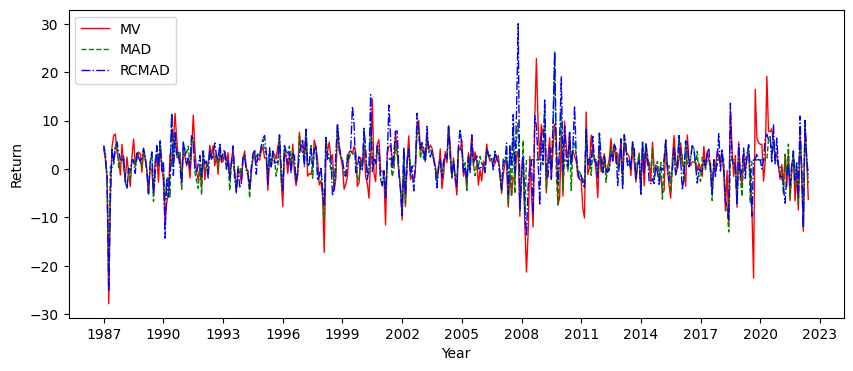

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# 生成时间序列，从1988年开始，每年增加1/12单位
start_year = 1987 + 1/2
end_year = 2022+11/12
x_values = np.arange(start_year, end_year + 1/12, 1/12)

# 设置图形的大小，长宽比为2.5:1
plt.figure(figsize=(10, 4))


# 绘制三个图形，设置颜色、线性和线宽
plt.plot(x_values, po_list, color='red', linestyle='-', linewidth=1, label='MV')
plt.plot(x_values, mad_list, color='green', linestyle='--', linewidth=1, label='MAD')
plt.plot(x_values, rcmad_list, color='blue', linestyle='-.', linewidth=1, label='RCMAD')

# 设置横坐标刻度
tick_positions = np.arange(start_year, end_year + 1, 3)
plt.xticks(tick_positions)
# 格式化刻度标签，保留整数部分
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
# 添加标题和标签
plt.xlabel('Year')
plt.ylabel('Return')
plt.legend()
# 保存图形为EPS格式
plt.savefig('result_compare.eps', format='eps')
plt.show()

In [ ]:
import csv
# 将列表组合成一个二维列表
data = [po_list, mad_list, rcmad_list]

# 指定要保存的CSV文件名
csv_file = "output.csv"

# 打开CSV文件并写入数据
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # 写入三个列表的标题行
    writer.writerow(["PO", "MAD", "RCMAD"])
    
    # 写入数据行
    for row in zip(*data):
        writer.writerow(row)

print(f"{csv_file} 文件已成功保存。")

print("Average PO is ", np.mean(po_list))
print("Average MAD is ", np.mean(mad_list))
print("Average RCMAD is ", np.mean(rcmad_list))

print("Max PO is ", np.max(po_list))
print("Max MAD is ", np.max(mad_list))
print("Max RCMAD is ", np.max(rcmad_list))

print("Min PO is ", np.min(po_list))
print("Min MAD is ", np.min(mad_list))
print("Min RCMAD is ", np.min(rcmad_list))

0.9661413944998961
1.2007632272688529
1.5771471184523733


In [ ]:
print(np.mean(po_list)/np.std(po_list)*np.sqrt(12))
print(np.mean(mad_list)/np.std(mad_list)*np.sqrt(12))
print(np.mean(rcmad_list)/np.std(rcmad_list)*np.sqrt(12))

0.6564452137746357
1.0570890840778573
1.1310742137020897
